In [2]:
# ============================================================
# Cell 1: Setup, imports, device, and seeding
# ============================================================

# MD_Notebook_YourName_ITAI.ipynb
# Midterm: Creating Images with Diffusion Models
# Dataset: MNIST (handwritten digits 0 to 9)

!pip install torch torchvision matplotlib einops -q

import math
import random
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from einops import rearrange

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Seed set to", SEED)

Using device: cuda
Seed set to 42


In [3]:
# ============================================================
# Cell 2: Dataset (MNIST), transforms, loaders
# ============================================================

IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 5  # You can increase to 10 or 20 if your GPU allows

transform = transforms.Compose([
    transforms.ToTensor(),                      # [0, 1]
    transforms.Normalize((0.5,), (0.5,))        # [-1, 1]
])

# Load MNIST train split
dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

print("MNIST dataset loaded.")
print("Total samples:", len(dataset))

# Train / validation split (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

# DataLoaders
num_workers = min(4, os.cpu_count() or 1)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=(device.type == "cuda")
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=(device.type == "cuda")
)

# Quick range check
batch = next(iter(train_loader))[0]
print("Batch shape:", batch.shape)
print("Min value:", batch.min().item(), "Max value:", batch.max().item())

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.52MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]

MNIST dataset loaded.
Total samples: 60000
Train samples: 48000, Val samples: 12000


Batch shape: torch.Size([64, 1, 28, 28])
Min value: -1.0 Max value: 1.0


In [4]:
# ============================================================
# Cell 3: Diffusion schedule and helper functions
# ============================================================

# Number of diffusion steps
T = 300  # enough for MNIST, not too heavy

# Linear beta schedule
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T, device=device)  # [T]

alpha = 1.0 - beta                              # [T]
alpha_cumprod = torch.cumprod(alpha, dim=0)     # [T]
alpha_cumprod_prev = F.pad(alpha_cumprod[:-1], (1, 0), value=1.0)

sqrt_alpha_cumprod = torch.sqrt(alpha_cumprod)
sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - alpha_cumprod)
sqrt_recip_alpha = torch.sqrt(1.0 / alpha)
posterior_variance = beta * (1.0 - alpha_cumprod_prev) / (1.0 - alpha_cumprod)

print("Diffusion schedule ready with", T, "steps.")


def sample_timesteps(batch_size):
    """Uniformly sample integer timesteps in [0, T-1]."""
    return torch.randint(low=0, high=T, size=(batch_size,), device=device)


def q_sample(x0, t, noise=None):
    """
    Forward diffusion: q(x_t | x_0).
    x0: original image, shape [B, C, H, W]
    t:  timestep indices, shape [B]
    """
    if noise is None:
        noise = torch.randn_like(x0)

    # gather correct alphas for each element in batch
    sqrt_alpha_cumprod_t = sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)

    return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise, noise

Diffusion schedule ready with 300 steps.


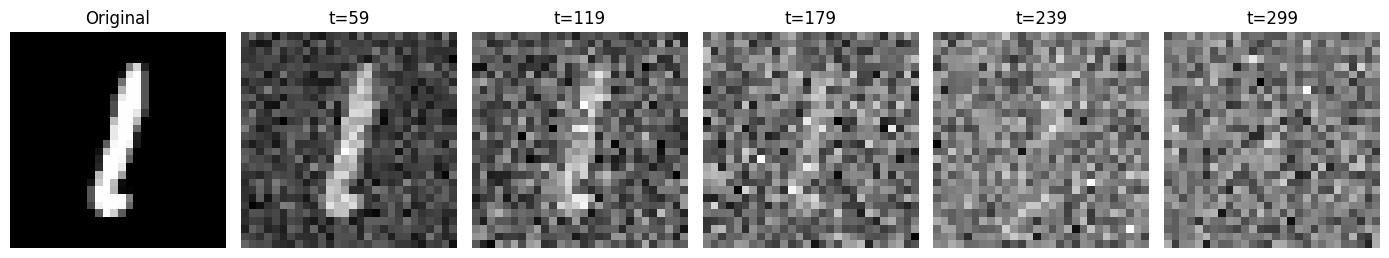

In [5]:
# ============================================================
# Cell 4: Visualize forward diffusion (noise progression)
# ============================================================

def show_noise_progression(loader, num_steps=6):
    model_input, _ = next(iter(loader))
    model_input = model_input.to(device)[:1]  # one image
    x0 = model_input[0]  # [C, H, W]

    plt.figure(figsize=(14, 3))
    plt.subplot(1, num_steps, 1)
    plt.title("Original")
    plt.axis("off")
    plt.imshow(x0[0].cpu(), cmap="gray")

    for i in range(1, num_steps):
        t = torch.tensor([int((i / (num_steps - 1)) * (T - 1))], device=device)
        xt, _ = q_sample(model_input, t)
        plt.subplot(1, num_steps, i + 1)
        plt.axis("off")
        plt.title(f"t={t.item()}")
        plt.imshow(xt[0, 0].detach().cpu(), cmap="gray")

    plt.tight_layout()
    plt.show()

show_noise_progression(train_loader, num_steps=6)

In [6]:
# ============================================================
# Cell 5: Time embedding and U-Net building blocks (FIXED)
# ============================================================

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        """
        t: [B] integer timesteps
        returns: [B, dim]
        """
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        return emb


class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, class_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.class_mlp = nn.Linear(class_emb_dim, out_ch)

        self.act = nn.SiLU()
        self.bn1 = nn.GroupNorm(8, out_ch)
        self.bn2 = nn.GroupNorm(8, out_ch)

        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb, c_emb):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.act(h)

        # Conditioning
        t_out = self.time_mlp(t_emb).view(t_emb.size(0), -1, 1, 1)
        c_out = self.class_mlp(c_emb).view(c_emb.size(0), -1, 1, 1)
        h = h + t_out + c_out

        h = self.conv2(h)
        h = self.bn2(h)
        h = self.act(h)
        return h + self.skip(x)


class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, class_emb_dim):
        super().__init__()
        self.res1 = ResidualBlock(in_ch, out_ch, time_emb_dim, class_emb_dim)
        self.res2 = ResidualBlock(out_ch, out_ch, time_emb_dim, class_emb_dim)
        self.down = nn.Conv2d(out_ch, out_ch, 4, stride=2, padding=1)

    def forward(self, x, t_emb, c_emb):
        x = self.res1(x, t_emb, c_emb)
        x = self.res2(x, t_emb, c_emb)
        skip = x
        x = self.down(x)
        return x, skip


# -------- FIXED UPBLOCK BELOW --------
class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, time_emb_dim, class_emb_dim):
        super().__init__()

        # Upsample reduces channels from in_ch → out_ch
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 4, stride=2, padding=1)

        # After concatenation: (out_ch + skip_ch)
        self.res1 = ResidualBlock(out_ch + skip_ch, out_ch, time_emb_dim, class_emb_dim)
        self.res2 = ResidualBlock(out_ch, out_ch, time_emb_dim, class_emb_dim)

    def forward(self, x, skip, t_emb, c_emb):
        x = self.up(x)                # shape → [B, out_ch, H*2, W*2]
        x = torch.cat([x, skip], dim=1)  # concat channels
        x = self.res1(x, t_emb, c_emb)
        x = self.res2(x, t_emb, c_emb)
        return x


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

# ============================================================
# Cell 6: U-Net model with time + class conditioning (FIXED)
# ============================================================

class UNet(nn.Module):
    def __init__(self, img_ch=1, base_ch=32, time_emb_dim=128, class_emb_dim=128, num_classes=10):
        super().__init__()

        # Time and class embeddings
        self.time_emb = SinusoidalTimeEmbedding(time_emb_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.class_emb = nn.Embedding(num_classes, class_emb_dim)
        self.class_mlp = nn.Sequential(
            nn.Linear(class_emb_dim, class_emb_dim),
            nn.SiLU(),
            nn.Linear(class_emb_dim, class_emb_dim)
        )

        # Initial
        self.initial_conv = nn.Conv2d(img_ch, base_ch, 3, padding=1)

        # -------------------------
        # Downsampling
        # -------------------------
        # 1 → 32 → 64
        self.down1 = DownBlock(base_ch, base_ch * 2, time_emb_dim, class_emb_dim)
        # 64 → 128
        self.down2 = DownBlock(base_ch * 2, base_ch * 4, time_emb_dim, class_emb_dim)

        # Bottleneck
        self.bottleneck1 = ResidualBlock(base_ch * 4, base_ch * 4, time_emb_dim, class_emb_dim)
        self.bottleneck2 = ResidualBlock(base_ch * 4, base_ch * 4, time_emb_dim, class_emb_dim)

        # -------------------------
        # Upsampling (FIXED)
        # -------------------------
        # UpBlock(in_ch, skip_ch, out_ch)
        # The skip connections are d1 (base_ch * 2) and d2 (base_ch * 4)
        # up1 receives from bottleneck (base_ch * 4) and skip2 (base_ch * 4)
        self.up1 = UpBlock(base_ch * 4, base_ch * 4, base_ch * 2, time_emb_dim, class_emb_dim)  # 128,128 → 64
        # up2 receives from up1 (base_ch * 2) and skip1 (base_ch * 2)
        self.up2 = UpBlock(base_ch * 2, base_ch * 2, base_ch, time_emb_dim, class_emb_dim)          # 64,64 → 32

        # Final conv
        self.final_conv = nn.Sequential(
            nn.Conv2d(base_ch, base_ch, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_ch, img_ch, 3, padding=1)
        )

    def forward(self, x, t, y):
        # Embeddings
        t_emb = self.time_mlp(self.time_emb(t))
        c_emb = self.class_mlp(self.class_emb(y))

        # Down
        x = self.initial_conv(x)
        d1, skip1 = self.down1(x, t_emb, c_emb)
        d2, skip2 = self.down2(d1, t_emb, c_emb)

        # Bottleneck
        b = self.bottleneck1(d2, t_emb, c_emb)
        b = self.bottleneck2(b, t_emb, c_emb)

        # Up (FIXED)
        u1 = self.up1(b, skip2, t_emb, c_emb)
        u2 = self.up2(u1, skip1, t_emb, c_emb)

        return self.final_conv(u2)

In [8]:
# ============================================================
# Cell 7: Training step and loss
# ============================================================

model = UNet(
    img_ch=IMG_CH,
    base_ch=32,
    time_emb_dim=128,
    class_emb_dim=128,
    num_classes=N_CLASSES
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print("Model parameters:", sum(p.numel() for p in model.parameters()) / 1e6, "M")

def diffusion_loss(model, x0, y):
    """
    One training step loss:
    1. sample timestep t
    2. add noise to x0 -> x_t
    3. have model predict noise
    4. MSE between predicted noise and actual noise
    """
    b = x0.size(0)
    t = sample_timesteps(b)  # [B]
    x_t, noise = q_sample(x0, t)
    noise_pred = model(x_t, t, y)
    return F.mse_loss(noise_pred, noise)

Model parameters: 2.325953 M


Epoch 1/5 | Train Loss: 0.0687 | Val Loss: 0.0481
Epoch 2/5 | Train Loss: 0.0459 | Val Loss: 0.0435
Epoch 3/5 | Train Loss: 0.0431 | Val Loss: 0.0419
Epoch 4/5 | Train Loss: 0.0421 | Val Loss: 0.0415
Epoch 5/5 | Train Loss: 0.0412 | Val Loss: 0.0401


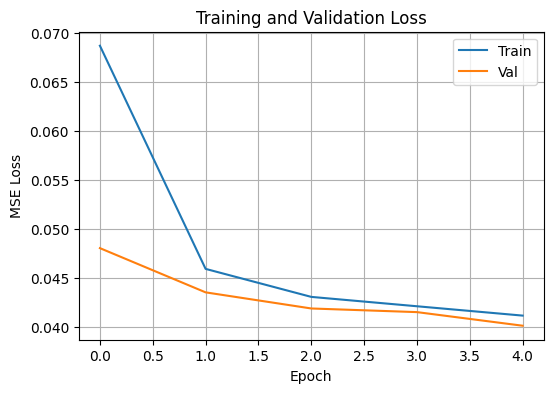

In [9]:
# ============================================================
# Cell 8: Training loop
# ============================================================

train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_train_loss = 0.0
    for x, y in train_loader:
        x = x.to(device)   # [B,1,28,28]
        y = y.to(device)   # [B]

        optimizer.zero_grad()
        loss = diffusion_loss(model, x, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_train_loss += loss.item() * x.size(0)

    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            loss = diffusion_loss(model, x, y)
            epoch_val_loss += loss.item() * x.size(0)

    epoch_val_loss /= len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# Plot loss curves
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()

In [10]:
# ============================================================
# Cell 9: Reverse diffusion (sampling) from pure noise
# ============================================================

@torch.no_grad()
def p_sample_step(x_t, t, y):
    """
    One reverse diffusion step p(x_{t-1} | x_t).
    Uses the model to predict noise, then uses DDPM formula.
    """
    b = x_t.size(0)
    t_tensor = torch.full((b,), t, device=device, dtype=torch.long)

    # Predict noise
    eps_theta = model(x_t, t_tensor, y)

    beta_t = beta[t]
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alpha_cumprod[t]
    sqrt_recip_alpha_t = sqrt_recip_alpha[t]
    posterior_var_t = posterior_variance[t]

    # reshape scaling factors
    beta_t = beta_t.view(1, 1, 1, 1)
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alpha_cumprod_t.view(1, 1, 1, 1)
    sqrt_recip_alpha_t = sqrt_recip_alpha_t.view(1, 1, 1, 1)
    posterior_var_t = posterior_var_t.view(1, 1, 1, 1)

    # DDPM mean
    model_mean = sqrt_recip_alpha_t * (
        x_t - beta_t / sqrt_one_minus_alpha_cumprod_t * eps_theta
    )

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x_t)
        return model_mean + torch.sqrt(posterior_var_t) * noise


@torch.no_grad()
def sample_digits(num_samples_per_class=4):
    """
    Generate samples for digits 0 to 9.
    Returns a grid image tensor.
    """
    model.eval()
    all_images = []
    all_labels = []

    for digit in range(N_CLASSES):
        y = torch.full((num_samples_per_class,), digit, device=device, dtype=torch.long)
        x_t = torch.randn(num_samples_per_class, IMG_CH, IMG_SIZE, IMG_SIZE, device=device)

        for t in reversed(range(T)):
            x_t = p_sample_step(x_t, t, y)

        all_images.append(x_t.cpu())
        all_labels.extend([digit] * num_samples_per_class)

    all_images = torch.cat(all_images, dim=0)  # [N_CLASSES*num_samples_per_class, 1, 28,28]
    # rescale from [-1,1] to [0,1] for plotting if needed
    imgs = (all_images + 1) / 2
    grid = make_grid(imgs, nrow=num_samples_per_class, padding=2)
    return grid

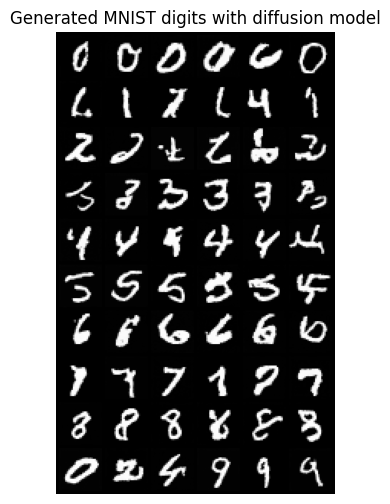

In [11]:
# ============================================================
# Cell 10: Visualize generated samples
# ============================================================

grid = sample_digits(num_samples_per_class=6)
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.title("Generated MNIST digits with diffusion model")
plt.imshow(grid.permute(1, 2, 0))
plt.show()

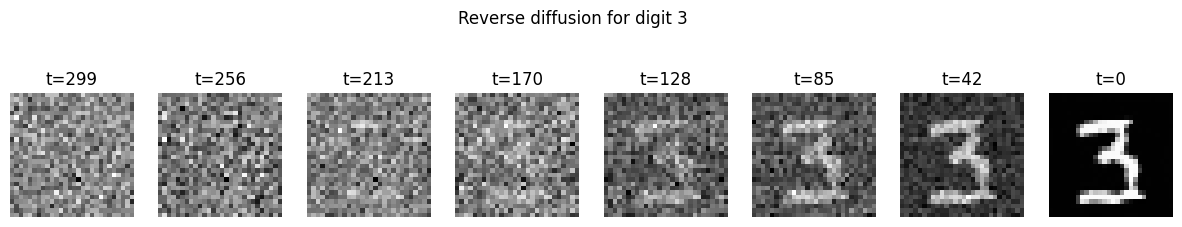

In [12]:
# ============================================================
# Cell 11: Visualize step by step denoising for a single digit
# ============================================================

@torch.no_grad()
def visualize_single_generation(digit=7, steps_to_show=8):
    model.eval()
    y = torch.full((1,), digit, device=device, dtype=torch.long)
    x_t = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE, device=device)

    # choose timesteps to record
    ts = np.linspace(T - 1, 0, steps_to_show, dtype=int)
    ts = sorted(set(ts), reverse=True)

    images = []
    current_t_index = 0
    for t in reversed(range(T)):
        x_t = p_sample_step(x_t, t, y)
        if t == ts[current_t_index]:
            images.append(x_t[0].cpu())
            current_t_index += 1
            if current_t_index >= len(ts):
                break

    # plot
    plt.figure(figsize=(15, 3))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.axis("off")
        plt.title(f"t={ts[i]}")
        img_vis = (img + 1) / 2
        plt.imshow(img_vis[0], cmap="gray")
    plt.suptitle(f"Reverse diffusion for digit {digit}")
    plt.show()

visualize_single_generation(digit=3, steps_to_show=8)